In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection configuration
config = {
    'host': '127.0.0.1',
    'user': 'root',
    'password': 'root',
    'database': 'spherych_devapp'
}

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Connect to database and fetch the data
def get_difficulty_exercise_data():
    """
    Fetches exercise data grouped by difficulty from the database
    """
    try:
        conn = mysql.connector.connect(**config)
        print("Database connection successful!")
        
        query = """
        SELECT
            rc.difficulty,
            AVG(w.totalTouches) as avg_touches,
            AVG(w.totalPunches) as avg_punches,
            AVG(w.totalJumps) as avg_jumps,
            AVG(w.totalSquats) as avg_squats,
            AVG(w.totalTripples) as avg_tripples,
            AVG(w.totalLunges) as avg_lunges,
            AVG(w.totalBurpees) as avg_burpees,
            COUNT(w.id) as workout_count
        FROM Workouts w
        JOIN RaceConfigs rc ON w.id = rc.workoutId
        GROUP BY rc.difficulty
        ORDER BY rc.difficulty;
        """
        
        df = pd.read_sql(query, conn)
        conn.close()
        
        return df
        
    except mysql.connector.Error as err:
        print(f"Database error: {err}")
        return None

# Fetch the data
df = get_difficulty_exercise_data()
if df is not None:
    print("Data fetched successfully!")
    print(f"Shape: {df.shape}")
    display(df)


Database connection successful!
Data fetched successfully!
Shape: (4, 9)


/var/folders/wn/kjhkcp0x4c94gmv1184_v4t00000gn/T/ipykernel_28259/4059879874.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,difficulty,avg_touches,avg_punches,avg_jumps,avg_squats,avg_tripples,avg_lunges,avg_burpees,workout_count
0,-1,111.6481,39.5953,28.5404,27.3571,3.3754,14.8619,7.8014,5357
1,0,86.5341,24.8109,7.9566,6.5051,0.0630,0.1729,0.0009,1240
2,1,121.7305,38.3009,24.4255,8.6444,2.0699,4.6738,0.1104,1103
3,2,92.0544,43.5974,25.0086,20.4129,2.5594,3.3230,7.1380,7914


In [3]:
# Define expected exercise patterns based on user input
expected_patterns = {
    'Beginner': ['touches', 'punches', 'jumps', 'squats'],
    'Intermediate': ['touches', 'punches', 'jumps', 'squats', 'tripples'],
    'Expert': ['touches', 'punches', 'jumps', 'squats', 'tripples', 'burpees']
}

# Function to classify difficulty based on exercise patterns
def classify_difficulty_by_exercises(row):
    """
    Classify difficulty level based on which exercises are present (avg > threshold)
    """
    threshold = 1.0  # Minimum average to consider an exercise "present"
    
    present_exercises = []
    if row['avg_touches'] > threshold:
        present_exercises.append('touches')
    if row['avg_punches'] > threshold:
        present_exercises.append('punches')
    if row['avg_jumps'] > threshold:
        present_exercises.append('jumps')
    if row['avg_squats'] > threshold:
        present_exercises.append('squats')
    if row['avg_tripples'] > threshold:
        present_exercises.append('tripples')
    if row['avg_burpees'] > threshold:
        present_exercises.append('burpees')
    
    # Check which expected pattern matches best
    for difficulty_name, expected_exercises in expected_patterns.items():
        if set(present_exercises) == set(expected_exercises):
            return difficulty_name
    
    # If no exact match, find closest match
    best_match = None
    best_score = 0
    
    for difficulty_name, expected_exercises in expected_patterns.items():
        # Calculate overlap score
        overlap = len(set(present_exercises) & set(expected_exercises))
        total = len(set(present_exercises) | set(expected_exercises))
        score = overlap / total if total > 0 else 0
        
        if score > best_score:
            best_score = score
            best_match = difficulty_name
    
    return f"{best_match} (partial match: {best_score:.2f})"

# Apply classification
if df is not None:
    df['predicted_difficulty'] = df.apply(classify_difficulty_by_exercises, axis=1)
    
    print("Classification Results:")
    print("=" * 50)
    for idx, row in df.iterrows():
        print(f"Difficulty {row['difficulty']}: {row['predicted_difficulty']}")
    
    display(df[['difficulty', 'predicted_difficulty', 'workout_count']])


Classification Results:
Difficulty -1: Expert
Difficulty 0: Beginner
Difficulty 1: Intermediate
Difficulty 2: Expert


,difficulty,predicted_difficulty,workout_count
0,-1,Expert,5357
1,0,Beginner,1240
2,1,Intermediate,1103
3,2,Expert,7914


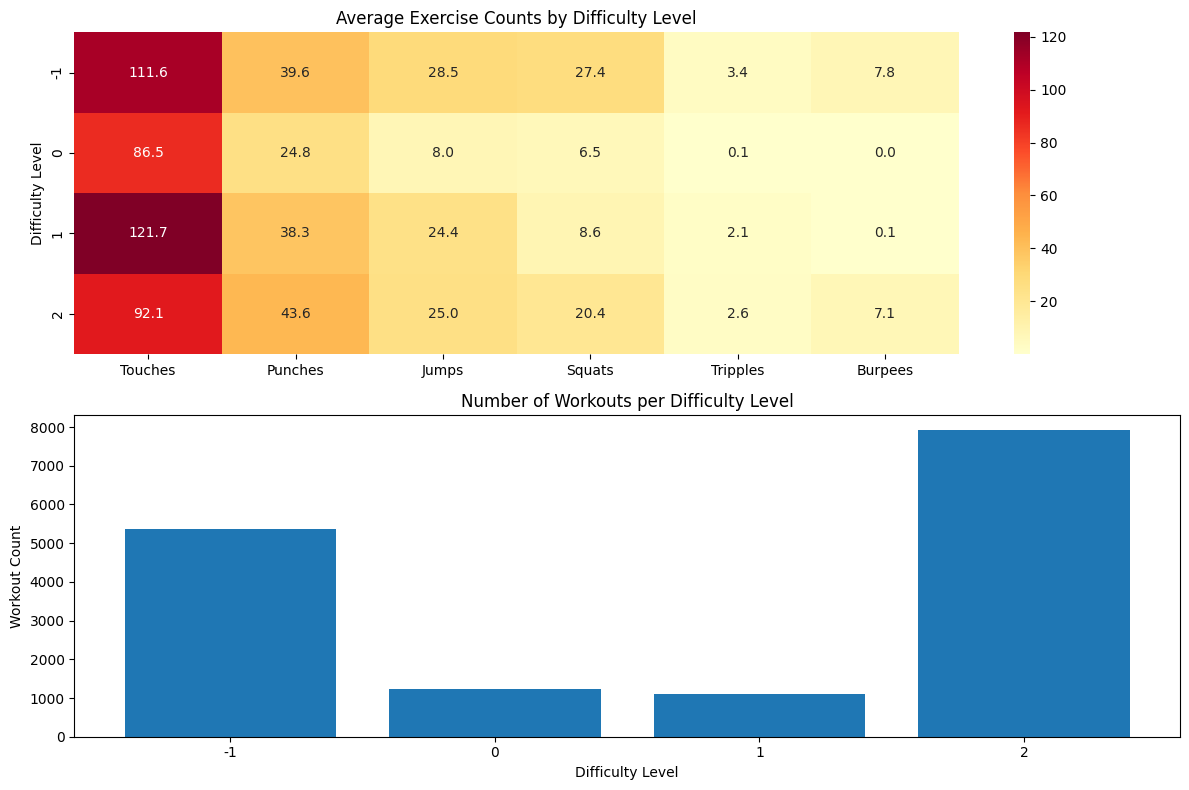

In [4]:
# Create visualization of exercise patterns by difficulty
if df is not None:
    # Prepare data for visualization
    exercise_cols = ['avg_touches', 'avg_punches', 'avg_jumps', 'avg_squats', 'avg_tripples', 'avg_burpees']
    
    # Create a heatmap
    plt.figure(figsize=(12, 8))
    
    # Create subplot for heatmap
    plt.subplot(2, 1, 1)
    heatmap_data = df[['difficulty'] + exercise_cols].set_index('difficulty')
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', 
                xticklabels=['Touches', 'Punches', 'Jumps', 'Squats', 'Tripples', 'Burpees'])
    plt.title('Average Exercise Counts by Difficulty Level')
    plt.ylabel('Difficulty Level')
    
    # Create bar plot for workout counts
    plt.subplot(2, 1, 2)
    plt.bar(df['difficulty'].astype(str), df['workout_count'])
    plt.title('Number of Workouts per Difficulty Level')
    plt.xlabel('Difficulty Level')
    plt.ylabel('Workout Count')
    
    plt.tight_layout()
    plt.show()


In [5]:
# Create detailed analysis table
if df is not None:
    print("DETAILED ANALYSIS RESULTS")
    print("=" * 80)
    
    # Create summary table
    summary_data = []
    
    for idx, row in df.iterrows():
        difficulty = row['difficulty']
        exercises = []
        
        # List exercises that are present (above threshold)
        if row['avg_touches'] > 1.0:
            exercises.append(f"Touches ({row['avg_touches']:.1f})")
        if row['avg_punches'] > 1.0:
            exercises.append(f"Punches ({row['avg_punches']:.1f})")
        if row['avg_jumps'] > 1.0:
            exercises.append(f"Jumps ({row['avg_jumps']:.1f})")
        if row['avg_squats'] > 1.0:
            exercises.append(f"Squats ({row['avg_squats']:.1f})")
        if row['avg_tripples'] > 1.0:
            exercises.append(f"Tripples ({row['avg_tripples']:.1f})")
        if row['avg_burpees'] > 1.0:
            exercises.append(f"Burpees ({row['avg_burpees']:.1f})")
        
        notes = f"{int(row['workout_count'])} workouts analyzed. Predicted: {row['predicted_difficulty']}"
        
        summary_data.append([
            difficulty,
            ", ".join(exercises) if exercises else "No significant exercises",
            notes
        ])
    
    summary_df = pd.DataFrame(summary_data, columns=[
        "Difficulty Rating", 
        "Associated Exercises/Subsets", 
        "Notes"
    ])
    
    display(summary_df)


DETAILED ANALYSIS RESULTS


,Difficulty Rating,Associated Exercises/Subsets,Notes
0,-1,"Touches (111.6), Punches (39.6), Jumps (28.5),...",5357 workouts analyzed. Predicted: Expert
1,0,"Touches (86.5), Punches (24.8), Jumps (8.0), S...",1240 workouts analyzed. Predicted: Beginner
2,1,"Touches (121.7), Punches (38.3), Jumps (24.4),...",1103 workouts analyzed. Predicted: Intermediate
3,2,"Touches (92.1), Punches (43.6), Jumps (25.0), ...",7914 workouts analyzed. Predicted: Expert
